In [388]:
import pandas as pd
import numpy as np
from autoviz.AutoViz_Class import AutoViz_Class
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as skm
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy.stats import boxcox
from scipy import special
import joblib
import shap

In [389]:
df = pd.read_csv(r"C:\Users\Dell\Desktop\ML course\WildBlueberry_YieldPrediction_Project3\Data\WildBlueberryPollinationSimulationData.csv")

In [390]:
df.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [391]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [392]:
df.drop(columns = 'Row#', inplace = True)

In [393]:
df.duplicated().sum()

0

In [394]:
df.isnull().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

Shape of your Data Set loaded: (777, 17)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    16 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Regression VISUALIZATION Started #####################


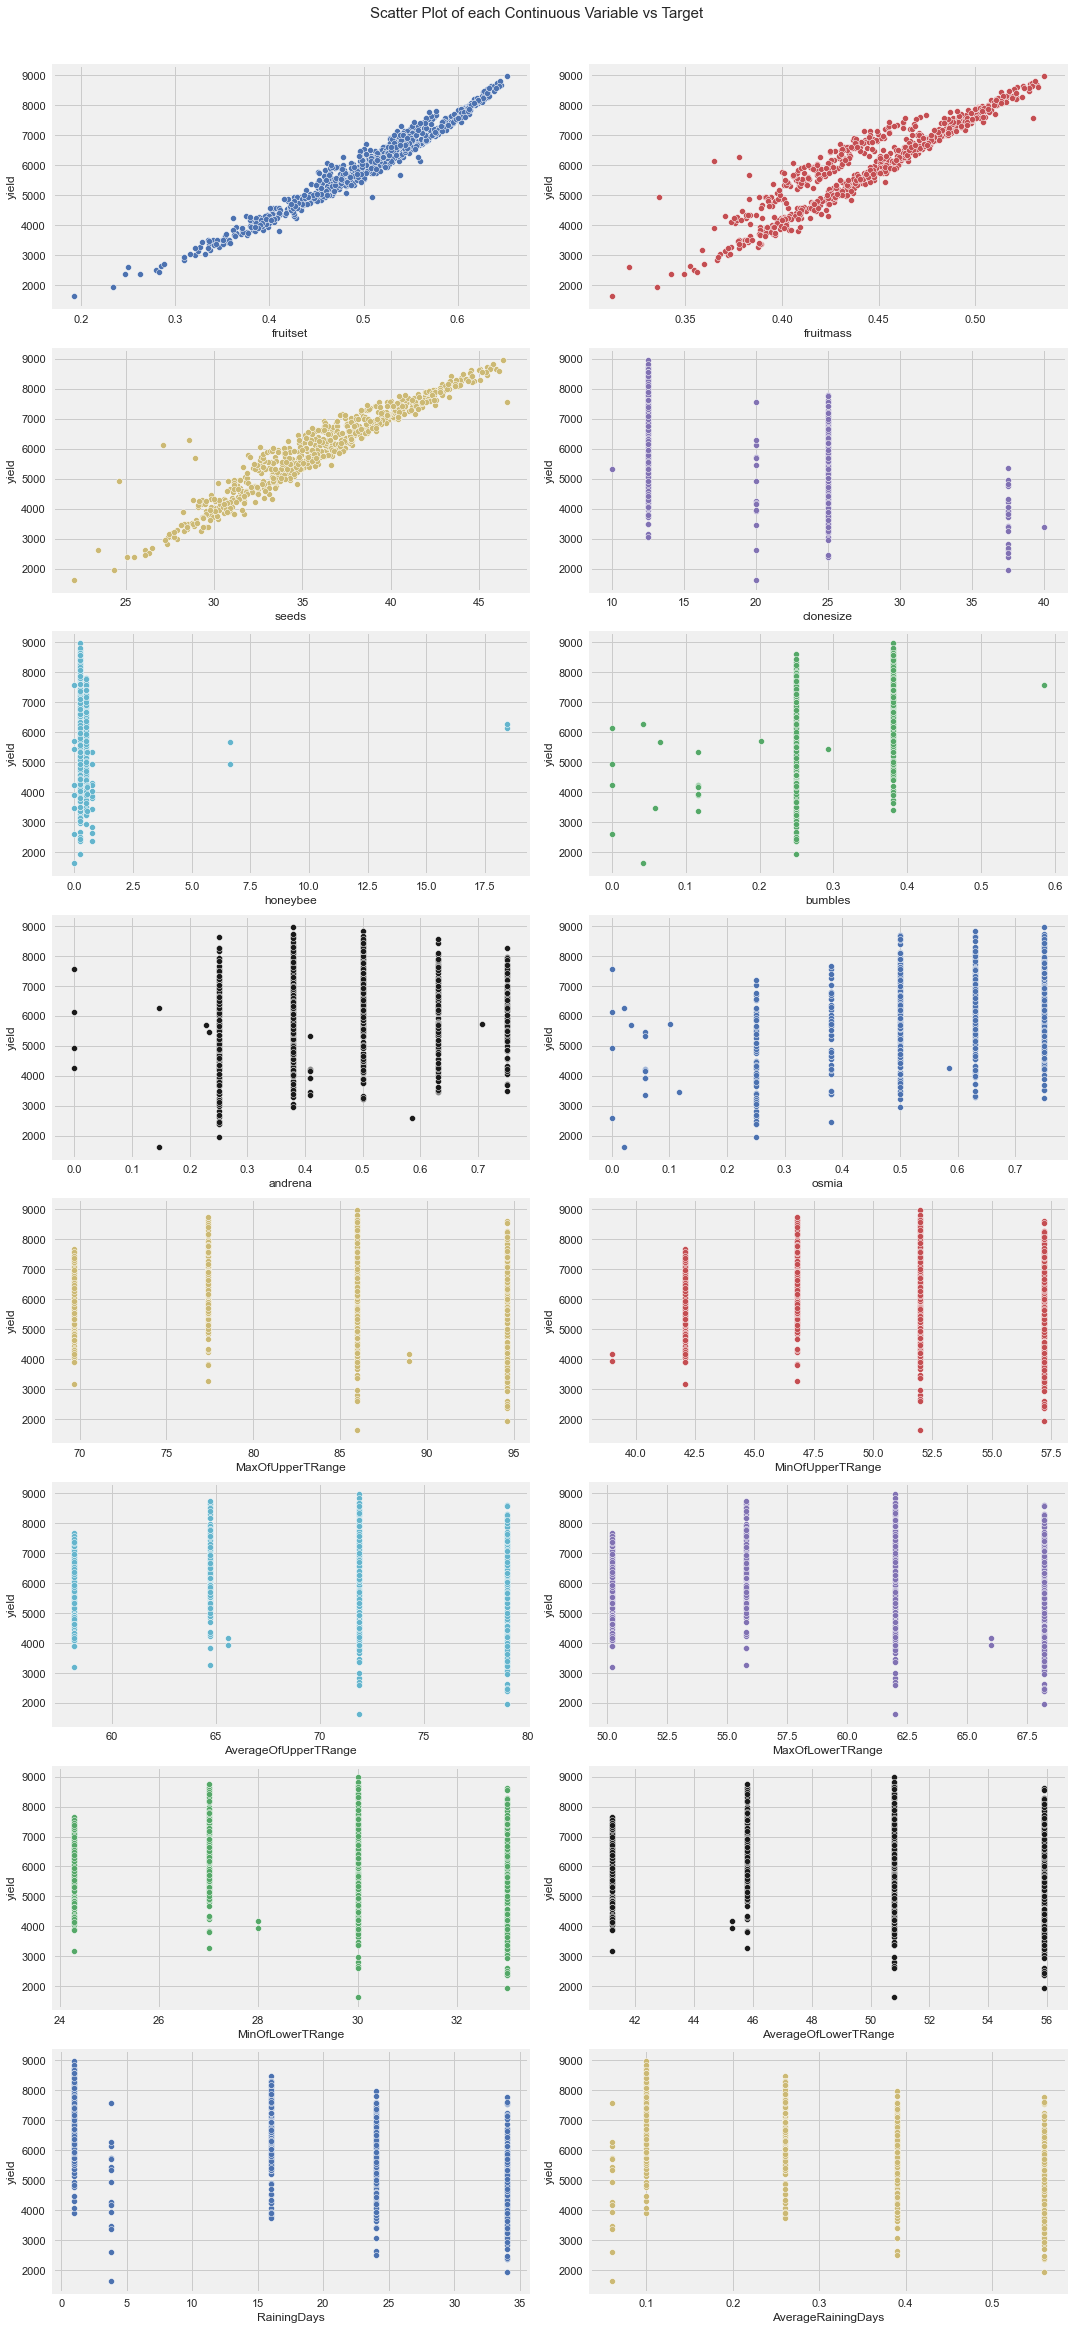

Number of All Scatter Plots = 136


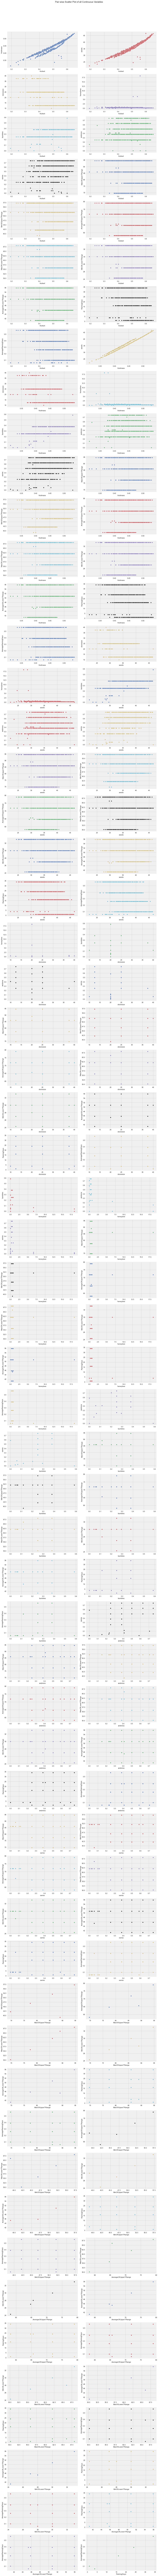

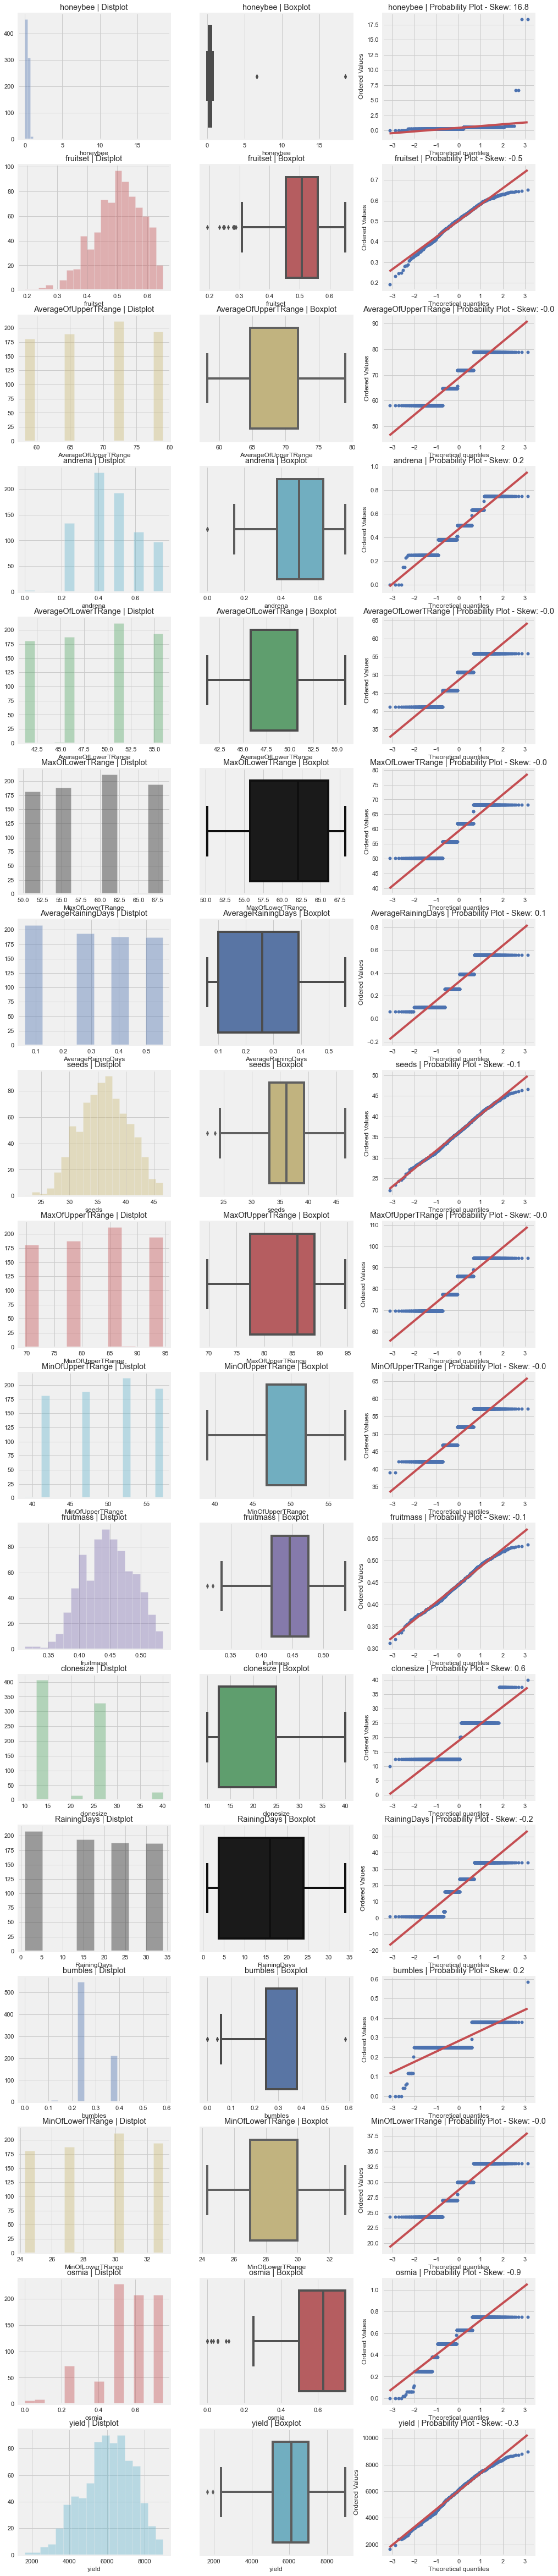

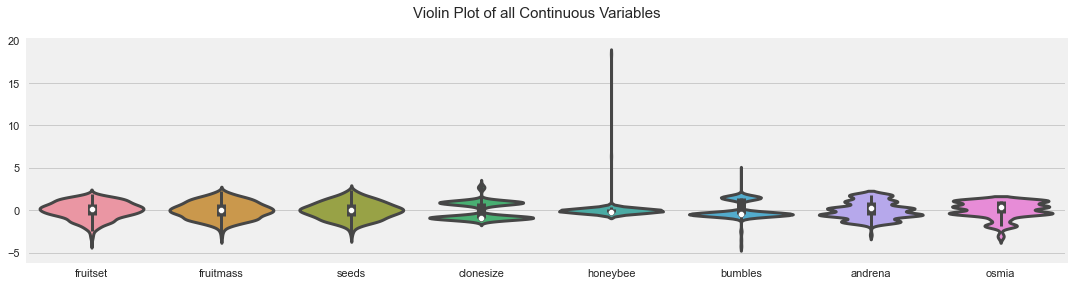

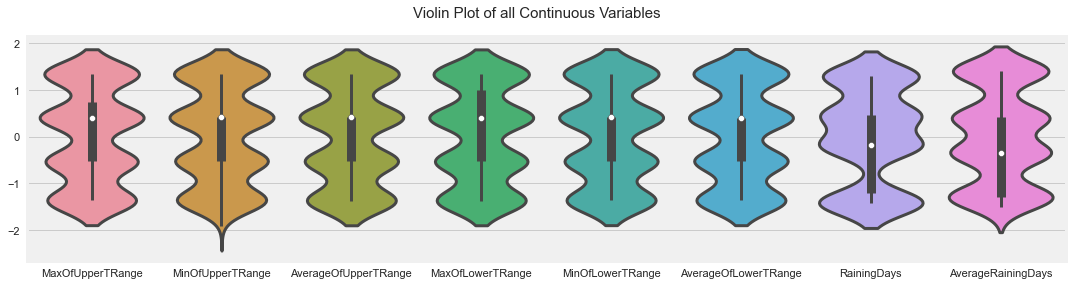

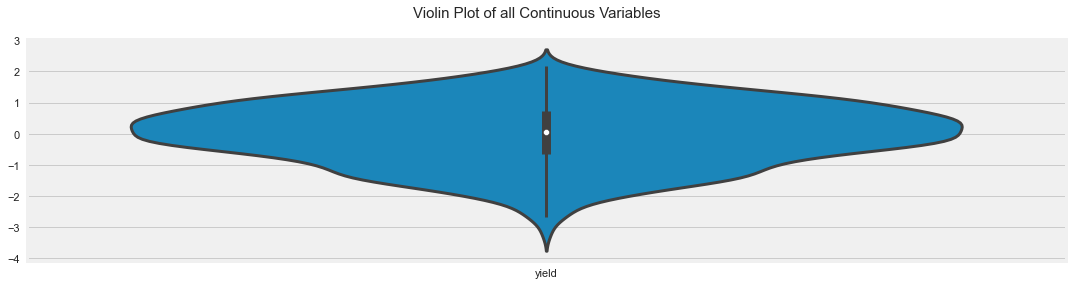

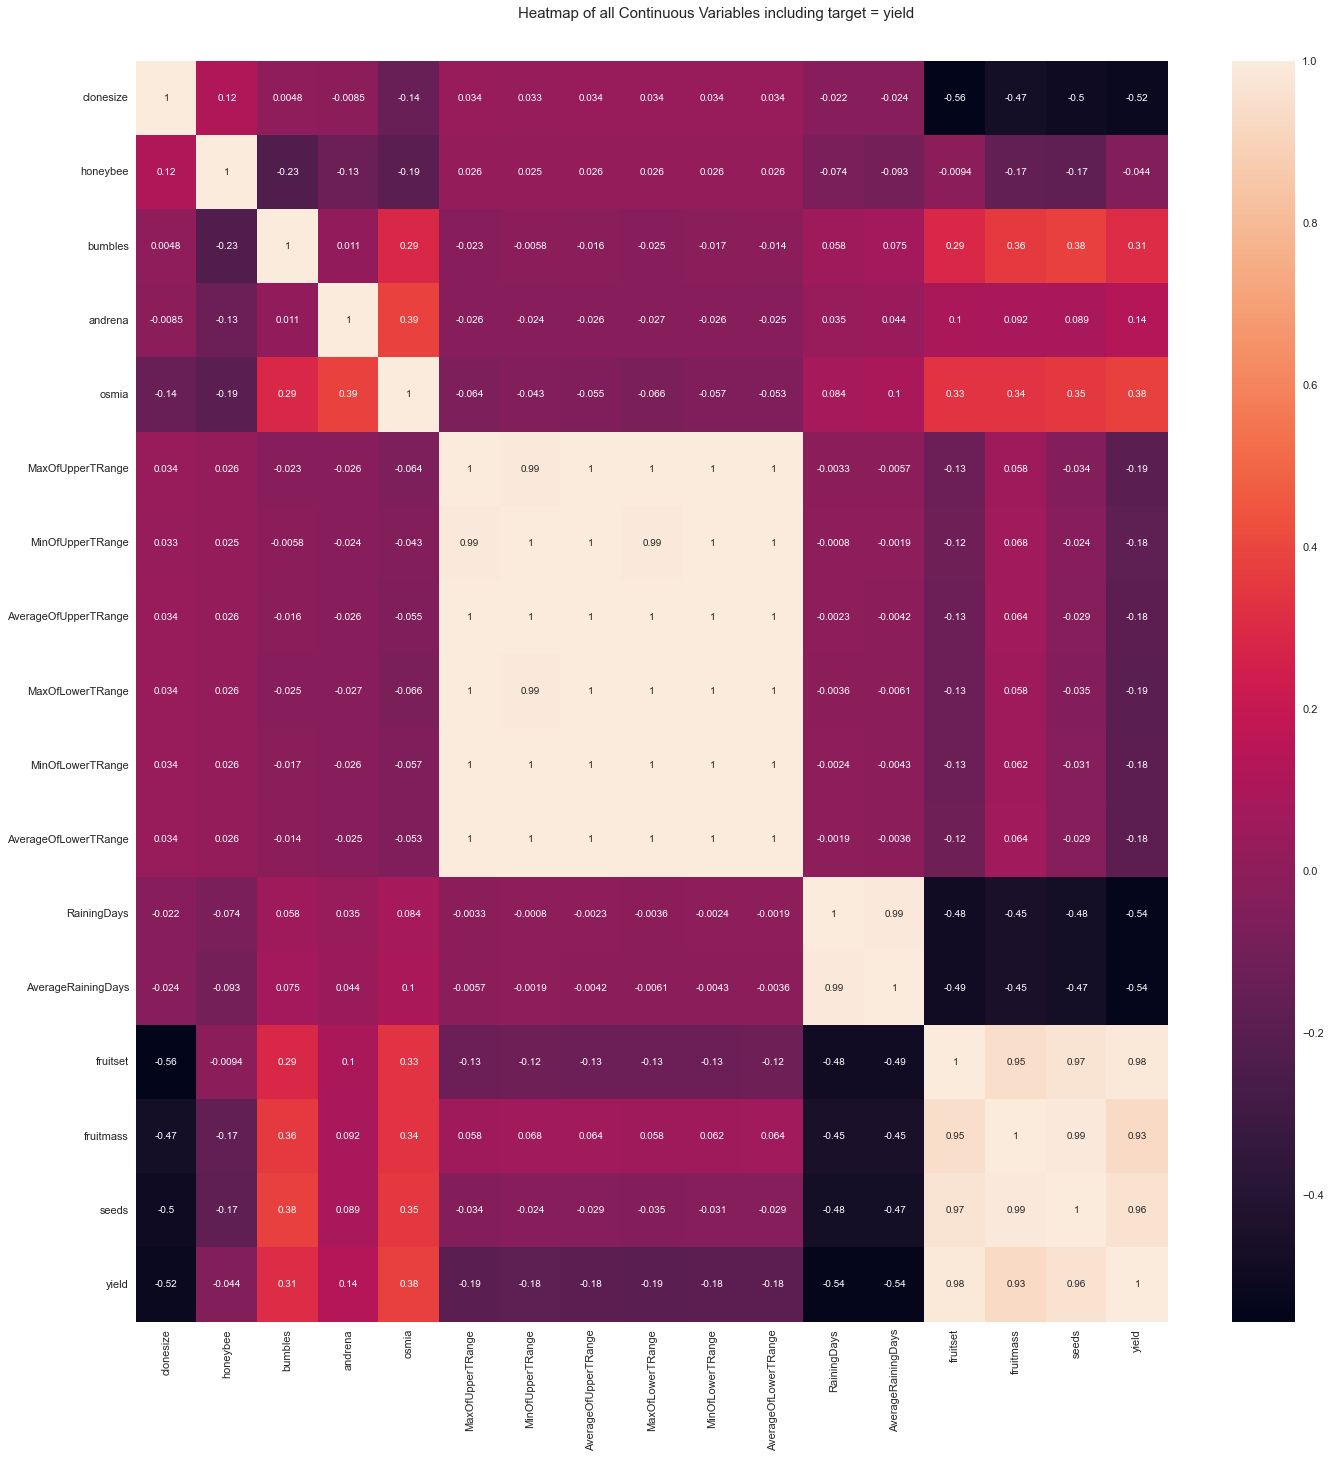

No categorical or boolean vars in data set. Hence no pivot plots...
No categorical or numeric vars in data set. Hence no bar charts.
All Plots done
Time to run AutoViz (in seconds) = 102

 ###################### VISUALIZATION Completed ########################


In [395]:
av = AutoViz_Class()
df = av.AutoViz(filename = '', depVar = 'yield', dfte = df)

## AutoViz Interpretations feature-wise ##

*1. fruitset directly impacts fruitmass and seeds, each positively impact yield (mass and seeds can be removed)
    i. Remove outliers in fruitset (<0.3)*
    
2. clonesize almost negatively impacts yield - need to investigate why

3. yield has been high even when honeybee density was low, hence being the most critical factor for pollination
    i. 4 outliers for honeybee - retaining as they directly impacted yield
    
4. 1 outlier in bumbles, but yield is high, let's retain in as of now

5. andrena and osmia have contributed to pollination in a similar manner, can 1 be removed bassed on heatmap, no - corr_coeff is just 0.4

*6. All 3 values of upper T band and lower T band each seem correlated, investigate based on heatmap
even upper and lower look similar - investigate*
    *i.min upper and max upper are perfectly co-related, remove 1*
    
7. RainingDays is similar to AverageRainingDays, select the least importance one to be removed

*8. Yield is left-skewed, which means the model may not predict well for smaller yields, hence class is imbalanced*

## Concepts on treating skewed distribution ##
1. log transformation: not applicable for features having negative values, preferred for right-skewed
2. square transformation: applied for left skewed
3. boxcox is more like an ensemble transformation, use it

In [396]:
# Feature Engineering
df.drop(columns = ['fruitmass','seeds','MinOfUpperTRange','AverageOfUpperTRange','MaxOfLowerTRange','MinOfLowerTRange','AverageOfLowerTRange','RainingDays'], inplace = True)

In [397]:
df.duplicated().sum()
df_original = df.copy()

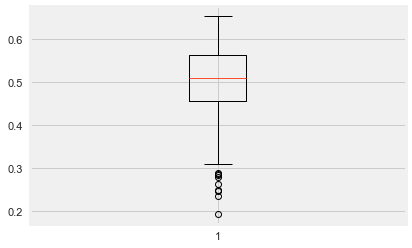

In [398]:
# Outlier treatment
plt.boxplot(df['fruitset'])
index_removed = df[df['fruitset']<0.24].index
df.drop(index = index_removed, inplace = True)

In [399]:
y = df['yield']
X = df.drop(columns = 'yield').copy()

In [400]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [402]:
# Use both tree-based and linear-based to check the results
# Tree-models don't need scaling unlike linear
params = {'booster' : 'gbtree', 'max_depth' : 6, 'learning_rate' : 0.1, 'sampling_method' : 'gradient_based'}
xgb_model = xgb.XGBRegressor()

In [404]:
transformed_data, lambda_value = boxcox(y_train)
print (y_train,'\n', transformed_data,'\n', lambda_value)

336    6852.979712
111    6808.263611
83     6986.809961
52     6691.043218
763    5686.121958
          ...     
72     4350.424670
107    7502.243890
271    6887.466493
436    8655.676437
103    6443.256903
Name: yield, Length: 542, dtype: float64 
 [122486.06000405 121399.28867281 125753.93195921 118562.64445389
  95001.06445479 133578.99399816  96221.33794322  88296.37509976
 119200.0232998  110907.2112682   62136.88788745  64015.1766187
 100958.11305078 121192.16187244 130546.48676001  99852.86642325
 128978.14544473  65160.80820818 109384.97838552 100225.25845197
 124353.07877157  47109.72755512  87148.87014761 142553.18708613
 107915.24590756 139881.8752989   78360.31891229 114558.36823242
 119542.51803661 110684.2736905   75617.80517363 140132.29098629
  78704.3098435  133111.77396325  78106.52672925  90758.26287342
 105307.42370196  95831.20196509 100185.32143412 145203.63434893
  89774.85299728 146206.82155848 126491.65622263 135519.63751914
 139039.24124934  76587.07922723 1

In [405]:
xgb_model.fit(X_train,transformed_data)
preds = xgb_model.predict(X_test)
preds = special.inv_boxcox(preds, lambda_value)
print (f'RSME from xgbregressor after transformation is {skm.mean_squared_error(y_test,preds, squared = False)}')
print (f'R2 score is {skm.r2_score(y_test,preds)}')

RSME from xgbregressor after transformation is 137.0802248034508
R2 score is 0.9906048352896859


In [406]:
xgb_model.get_xgb_params

<bound method XGBModel.get_xgb_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)>

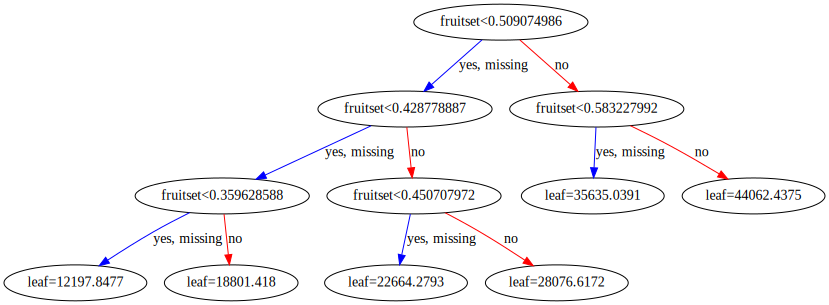

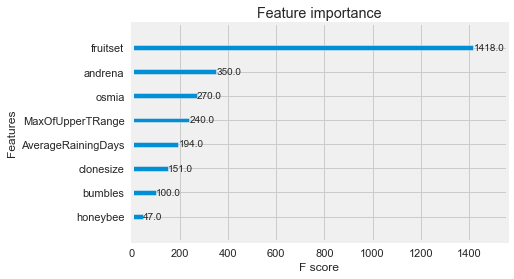

In [407]:
# Classification report of untuned model
xgb.plot_importance(xgb_model)
xgb.to_graphviz(xgb_model)

In [152]:
params = {'learning_rate':[0.2,0.3], 'l2_leaf_reg':[4,5]}
cb_tuned = CatBoostRegressor(random_state = 42)
# remove n_jobs = -1 to resolve the worker error
cb_grid = GridSearchCV(estimator = cb_tuned, param_grid = params, cv = 5, scoring = 'neg_root_mean_squared_error')
cb_grid.fit(X_train,y_train)

In [159]:
cb_grid.best_params_

{'l2_leaf_reg': 4, 'learning_rate': 0.2}

In [164]:
cb_tuned = CatBoostRegressor(random_state = 42, l2_leaf_reg = 4, learning_rate = 0.2)
cb_tuned.fit(X_train,y_train)
y_pred = cb_tuned.predict(X_test)
# Very high RSME from GB models, use catboost esp. when there cat features
skm.mean_squared_error(y_test,y_pred,squared = False)

In [408]:
X_train.drop(columns = ['honeybee'], inplace = True)
X_test.drop(columns = ['honeybee'], inplace = True)

In [409]:
transformed_data, lambda_value = boxcox(y_train)
xgb_model.fit(X_train,transformed_data)
preds = xgb_model.predict(X_test)
preds = special.inv_boxcox(preds, lambda_value)
lambda_value

1.3613740501599898

RSME from xgbregressor after feature engineering and transformation is 136.33327255554346
R2 score is 0.9907069451239096


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

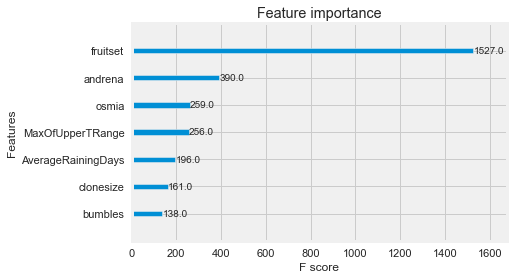

In [410]:
print (f'RSME from xgbregressor after feature engineering and transformation is {skm.mean_squared_error(y_test,preds, squared = False)}')
print (f'R2 score is {skm.r2_score(y_test,preds)}')
xgb.plot_importance(xgb_model)

## Explainable AI ##

In [411]:
shap.initjs()

In [412]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)
expected_value = explainer.expected_value

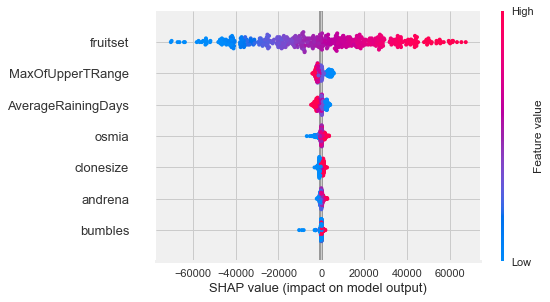

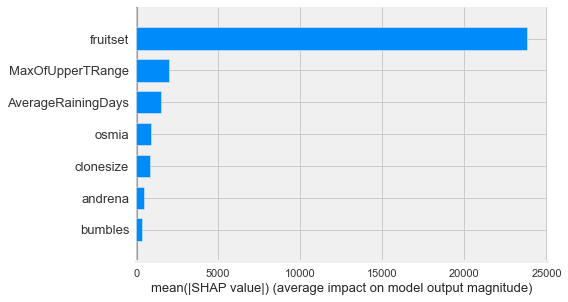

In [413]:
shap.summary_plot(shap_values,X_train)
shap.summary_plot(shap_values,X_train, plot_type = 'bar')

**Fruitset is directly proportional to the yield, lower values (blue) of fruitset have lower yield**

Temperature and raining days are narrowly distributed, for lower temperature or rain, the yield was high

osmia, andrena and bumbles directly impacted the yield

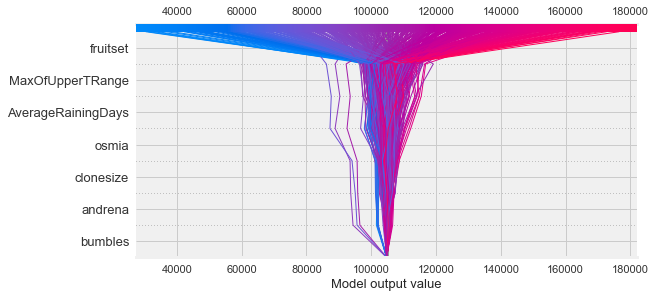

In [369]:
shap.decision_plot(expected_value,shap_values.values, feature_names)

In [373]:
feature_names = X_train.columns.tolist()
type(feature_names)

list

In [377]:
type(['clonesize', 'bumbles'])

list

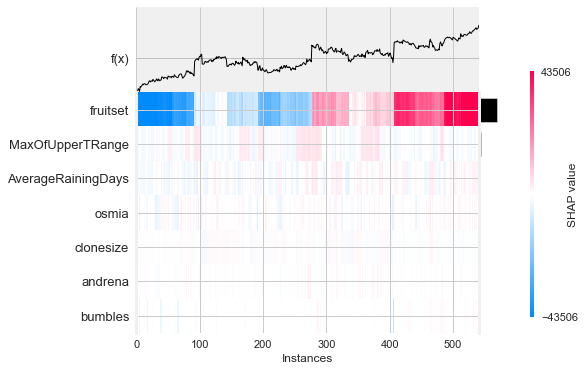

In [340]:
shap.plots.heatmap(shap_values)

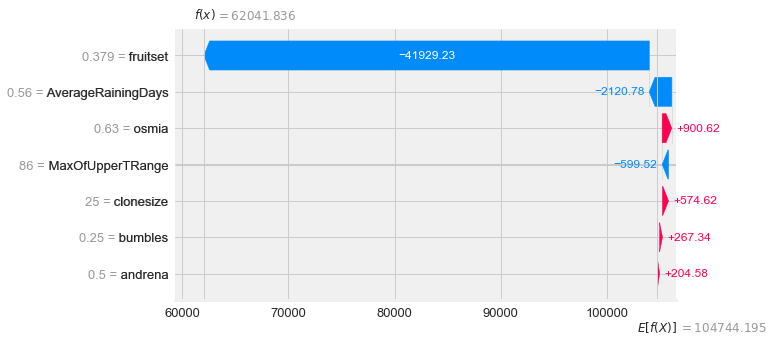

In [387]:
#for single observations
shap.plots.waterfall(shap_values[10])

In [344]:
#For testing
X_samp = np.array([0.3,0,0,0,86,0.47,0.42]).reshape(1,-1)
y_samp = xgb_model.predict(X_samp)
y_samp = special.inv_boxcox(y_samp, lambda_value)
y_samp

## Saving the model ##

In [285]:
joblib.dump(xgb_model,'XGBRegressor_model.joblib')

['XGBRegressor_model.joblib']

In [286]:
xgb_model = joblib.load('XGBRegressor_model.joblib')

In [321]:
predictions = xgb_model.predict(X_test)
predictions = special.inv_boxcox(predictions, lambda_value)

In [322]:
predictions

array([7410.831 , 6939.836 , 6708.0005, 7494.385 , 4407.756 , 4396.3535,
       7724.256 , 7240.402 , 5023.801 , 4967.294 , 3493.1313, 6877.401 ,
       4773.8247, 7067.412 , 5725.8555, 6803.5356, 3183.439 , 6647.729 ,
       7534.631 , 7421.8433, 5811.3486, 3252.7659, 6746.279 , 6262.1763,
       3381.7222, 5520.086 , 6072.051 , 7788.0435, 8306.432 , 3963.524 ,
       7753.4893, 6231.294 , 7491.6206, 5169.057 , 5406.1914, 5157.317 ,
       5404.989 , 7459.397 , 3200.211 , 6796.704 , 6806.4536, 5523.2915,
       6719.5625, 7545.3574, 5902.17  , 6305.9653, 4897.423 , 7252.537 ,
       6466.5615, 8072.5435, 6973.63  , 4572.4966, 6623.4014, 5716.638 ,
       5433.447 , 8644.494 , 5543.981 , 5558.956 , 2912.4526, 7337.8228,
       5845.608 , 2485.9756, 4855.77  , 6632.503 , 4059.514 , 5629.149 ,
       5839.0796, 6934.683 , 4496.5674, 5848.901 , 6644.6313, 7568.3013,
       7423.12  , 6648.5933, 5571.407 , 3426.9685, 7270.1245, 6233.4756,
       6217.0337, 5116.363 , 4714.265 , 7914.2437, 